### Reversed Knowledge Distillation

**Outline for Reversing the Teacher–Student Roles**

1. **Introduction and Motivation**  
   1.1. Recap of standard knowledge distillation (KD) setup (ResNet50 → ResNet34) on CIFAR‑10 citeturn0file1  
   1.2. Why reverse roles? Insights from Yuan et al. (2019) on “Reversed KD” citeturn0file1  

2. **Experimental Setup**  
   2.1. **Dataset**  
   &nbsp;&nbsp;• CIFAR‑10 splits; preprocessing and augmentations  
   2.2. **Models**  
   &nbsp;&nbsp;• ResNet50 (teacher) and ResNet34 (student) architectures  
   &nbsp;&nbsp;• ResNet34 (teacher) and ResNet50 (student) for reversed KD  
   2.3. **Implementation Environment**  
   &nbsp;&nbsp;• PyTorch version, hardware (GPU), random seeds for reproducibility  

3. **Baseline Training**  
   3.1. Train ResNet50 and ResNet34 *from scratch* on CIFAR‑10 using hard labels  
   3.2. Record clean‐accuracy, FLOPs, and parameter counts  

4. **Forward Knowledge Distillation (T → S)**  
   4.1. Hyperparameters: temperature τ, loss weight α citeturn0file1  
   4.2. Generate soft‐labels from ResNet50 at temperature τ  
   4.3. Train ResNet34 with combined hard‐label + KD loss  
   4.4. Evaluate distilled ResNet34; log metrics  

5. **Reversed Knowledge Distillation (S → T)**  
   5.1. Swap roles: use *trained* ResNet34 to generate soft‐labels  
   5.2. Train ResNet50 student on those soft‐labels (same τ, α)  
   5.3. Evaluate “reversed” distilled ResNet50; log metrics  

6. **Hyperparameter Tuning and Ablations**  
   6.1. Sweep over temperatures (e.g., {1, 5, 10, 20}) and α values  
   6.2. Compare forward vs. reversed KD performance under each setting  
   6.3. Optional: evaluate effect of “poorly‐trained” teacher checkpoints  

7. **Evaluation and Analysis**  
   7.1. **Quantitative Metrics**  
   &nbsp;&nbsp;• Test accuracy improvements over baselines  
   &nbsp;&nbsp;• Δ‑accuracy for forward vs. reversed KD  
   &nbsp;&nbsp;• Computational overhead (FLOPs, parameters)  
   7.2. **Visualizations**  
   &nbsp;&nbsp;• Accuracy vs. temperature curves  
   &nbsp;&nbsp;• Bar plots of Δ‑accuracy forward vs. reverse  
   7.3. **Discussion**  
   &nbsp;&nbsp;• Interpretation of why a smaller student can teach a larger model  
   &nbsp;&nbsp;• Relation to label‐smoothing–as–regularization view citeturn0file1  

8. **Reproducibility and Code Organization**  
   8.1. Directory structure: data/, models/, scripts/  
   8.2. Example command‐line usage for each experiment  
   8.3. Random seeds and logging  

---

**Task Breakdown**

Part 1. **Data Preparation**  
   - Download CIFAR‑10; implement augmentations and normalizations.  
   - Create PyTorch DataLoaders for train/test.

part 2. **Model Definitions**  
   - Instantiate ResNet50 and ResNet34 in PyTorch.  
   - Verify parameter counts and FLOPs via summary.

part 3. **Baseline Training**  
   - Write training loop for hard‐label training of both networks.  
   - Log accuracy and compute FLOPs/params.**Implement Forward KD**  
   - Add softmax with temperature τ to teacher.  
   - Define KD loss (KLDiv) + hard‐label cross‐entropy.  
   - Train student; save checkpoints. **Implement Reversed KD**  
   - Load trained student (ResNet34) as teacher.  
   - Repeat distillation protocol for ResNet50.  
   - Save and log metrics.

part 4. **Hyperparameter Sweeps**  
   - Automate experiments over τ ∈ {1,5,10,20} and α ∈ {0.1,0.5,0.9}.  
   - Collect results in a table for comparison.

part 5. **Evaluation & Visualization**  
   - Plot accuracy vs. τ for both forward/reverse KD.  
   - Create bar charts of Δ‑accuracy.  
   - Tabulate final metrics.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/661project"
!pwd

/content/drive/MyDrive/661project
/content/drive/MyDrive/661project


In [ ]:
pip install torch torchvision numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 135.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

# part1: Data Preparation

Download CIFAR‑10; implement augmentations and normalizations.

Create PyTorch DataLoaders for train/test.#

In [ ]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 1. Locate the cifar‑10 folder automatically
project_dir = os.getcwd()  # e.g. /content/drive/.../661project
cifar_dirs = [d for d in os.listdir(project_dir) if d.lower().startswith("cifar")]
if not cifar_dirs:
    raise FileNotFoundError("No folder starting with 'cifar' found in project directory")
DATA_ROOT = os.path.join(project_dir, cifar_dirs[0])
print("DATA_ROOT =", DATA_ROOT)

# 2. Normalization statistics for CIFAR‑10
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD  = [0.2470, 0.2435, 0.2616]

# 3. Train / test transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# 4. Helper to unpickle CIFAR batch files
def _unpickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f, encoding='latin1')

# 5. Custom Dataset for CIFAR‑10
class CIFAR10Py(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.transform = transform
        files = [f"data_batch_{i}" for i in range(1,6)] if train else ["test_batch"]
        data_list, labels = [], []
        for fn in files:
            batch = _unpickle(os.path.join(root, fn))
            data_list.append(batch['data'])
            labels += batch['labels']
        arr = np.vstack(data_list)              # shape (N, 3072)
        self.data   = arr.reshape(-1, 3, 32, 32) # shape (N, C, H, W)
        self.labels = np.array(labels, np.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.data[idx]                    # (3,32,32) uint8
        lbl = int(self.labels[idx])

        # --- FIX: transpose to H×W×C before PIL ---
        img = img.transpose(1,2,0)             # now (32,32,3)
        img = Image.fromarray(img)             # PIL image

        if self.transform:
            img = self.transform(img)
        return img, lbl

# 6. DataLoaders
train_ds = CIFAR10Py(DATA_ROOT, train=True,  transform=train_transform)
test_ds  = CIFAR10Py(DATA_ROOT, train=False, transform=test_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 7. Sanity check
imgs, labs = next(iter(train_loader))
print("imgs", imgs.shape, "| labs", labs.shape)
print("pixel range:", imgs.min().item(), "→", imgs.max().item())


DATA_ROOT = /content/drive/MyDrive/661project/cifar-10-batches-py
imgs torch.Size([128, 3, 32, 32]) | labs torch.Size([128])
pixel range: -1.9894737005233765 → 2.12648868560791


# part2: Model Definitions

Instantiate ResNet50 and ResNet34 in PyTorch.

Verify parameter counts and FLOPs via summary.

In [ ]:
!pip install torchinfo


In [ ]:
# 1. Imports
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary

# 2. Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)

# 3. Instantiate ResNet‑34 and ResNet‑50 (from scratch),
#    then override the final fc → 10 outputs for CIFAR‑10.
model34 = models.resnet34(pretrained=False)
model34.fc = nn.Linear(model34.fc.in_features, 10)
model34 = model34.to(device)

model50 = models.resnet50(pretrained=False)
model50.fc = nn.Linear(model50.fc.in_features, 10)
model50 = model50.to(device)

# 4. Dummy input shape for CIFAR‑10 (32×32)
dummy_input = (1, 3, 32, 32)

# 5. Print summaries
print("=== ResNet‑34 ===")
summary(
    model34,
    input_size=dummy_input,
    col_names=("input_size", "output_size", "num_params", "mult_adds"),
    verbose=0
)

print("\n=== ResNet‑50 ===")
summary(
    model50,
    input_size=dummy_input,
    col_names=("input_size", "output_size", "num_params", "mult_adds"),
    verbose=0
)


Running on: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


=== ResNet‑34 ===

=== ResNet‑50 ===


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
ResNet                                   [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                            [1, 3, 32, 32]            [1, 64, 16, 16]           9,408                     2,408,448
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           [1, 64, 16, 16]           128                       128
├─ReLU: 1-3                              [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           [1, 64, 8, 8]             --                        --
├─Sequential: 1-5                        [1, 64, 8, 8]             [1, 256, 8, 8]            --                        --
│    └─Bottleneck: 2-1                   [1, 64, 8, 8]             [1, 256, 8, 8]            --                        --
│    │   

# Part3: Baseline Training： ran 3 times

Write training loop for hard‐label training of both networks.

Log accuracy and compute FLOPs/params.



In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import models
import numpy as np

# ----------------------------
# assume train_loader, test_loader, device defined above
# ----------------------------
NUM_EPOCHS    = 200
LEARNING_RATE = 0.1
MOMENTUM      = 0.9
WEIGHT_DECAY  = 5e-4
MILESTONES    = [60, 120, 160]
GAMMA         = 0.1
TEMPERATURE   = 5
ALPHA         = 0.5

ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction='batchmean')

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

def train_one_epoch(model, optimizer, loader):
    model.train()
    total_corr = total_n = 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = ce_loss(out, lbls)
        loss.backward()
        optimizer.step()
        preds = out.argmax(1)
        total_corr += (preds == lbls).sum().item()
        total_n    += imgs.size(0)
    return 100. * total_corr / total_n

def evaluate(model, loader):
    model.eval()
    total_corr = total_n = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            preds = out.argmax(1)
            total_corr += (preds == lbls).sum().item()
            total_n    += imgs.size(0)
    return 100. * total_corr / total_n

def run_distillation(teacher, student):
    teacher.eval()
    for p in teacher.parameters(): p.requires_grad=False

    # reset student weights
    student.apply(lambda m: m.reset_parameters()
                  if hasattr(m, 'reset_parameters') else None)
    student.to(device)

    optim_s = optim.SGD(student.parameters(),
                        lr=LEARNING_RATE,
                        momentum=MOMENTUM,
                        weight_decay=WEIGHT_DECAY)
    sched_s = MultiStepLR(optim_s, milestones=MILESTONES, gamma=GAMMA)

    best_acc = 0.0
    for epoch in range(1, NUM_EPOCHS+1):
        student.train()
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optim_s.zero_grad()

            with torch.no_grad():
                t_logits = teacher(imgs)
                t_soft   = nn.functional.softmax(t_logits / TEMPERATURE, dim=1)

            s_logits   = student(imgs)
            s_log_soft = nn.functional.log_softmax(s_logits / TEMPERATURE, dim=1)

            loss_kd = kl_loss(s_log_soft, t_soft) * (TEMPERATURE**2)
            loss_ce = ce_loss(s_logits, lbls)
            (ALPHA * loss_kd + (1-ALPHA) * loss_ce).backward()
            optim_s.step()

        sched_s.step()
        val_acc = evaluate(student, test_loader)
        best_acc = max(best_acc, val_acc)

    return best_acc

# ─── Prepare storage lists ───────────────────────────────────────────────────
teacher_baselines   = []
student_baselines   = []
reverse_kd_results  = []

# ─── Main loop: 3 full runs ───────────────────────────────────────────────────
for run in range(3):
    seed = 42 + run*100
    print(f"\n\n=== RUN {run+1} (seed={seed}) ===")
    set_seed(seed)

    ckpt_dir = f"./checkpoints_run{run+1}"
    os.makedirs(ckpt_dir, exist_ok=True)

    # 1) Train ResNet-34 baseline (will be student in reverse KD)
    t34    = models.resnet34(pretrained=False).to(device)
    opt34  = optim.SGD(t34.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    sched34= MultiStepLR(opt34, milestones=MILESTONES, gamma=GAMMA)
    best34 = 0.0
    for ep in range(1, NUM_EPOCHS+1):
        train_one_epoch(t34, opt34, train_loader)
        val_acc = evaluate(t34, test_loader)
        sched34.step()
        best34 = max(best34, val_acc)
    torch.save(t34.state_dict(), os.path.join(ckpt_dir, "ResNet34_best.pth"))
    student_baselines.append(best34)
    print(f"→ Teacher baseline (ResNet-34) best = {best34:.2f}%")

    # 2) Train ResNet-50 baseline (will be teacher in reverse KD)
    t50    = models.resnet50(pretrained=False).to(device)
    opt50  = optim.SGD(t50.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    sched50= MultiStepLR(opt50, milestones=MILESTONES, gamma=GAMMA)
    best50 = 0.0
    for ep in range(1, NUM_EPOCHS+1):
        train_one_epoch(t50, opt50, train_loader)
        val_acc = evaluate(t50, test_loader)
        sched50.step()
        best50 = max(best50, val_acc)
    torch.save(t50.state_dict(), os.path.join(ckpt_dir, "ResNet50_best.pth"))
    teacher_baselines.append(best50)
    print(f"→ Student baseline (ResNet-50) best = {best50:.2f}%")

    # 3) Reverse KD: ResNet-34 → ResNet-50
    teacher34 = models.resnet34(pretrained=False).to(device)
    teacher34.load_state_dict(torch.load(os.path.join(ckpt_dir, "ResNet34_best.pth")))
    rev_acc = run_distillation(teacher34, models.resnet50(pretrained=False).to(device))
    reverse_kd_results.append(rev_acc)
    print(f"→ Re‑KD (S→T) best = {rev_acc:.2f}%")

# ─── Print summary ────────────────────────────────────────────────────────────
def mean_std(xs):
    return f"{np.mean(xs):.2f}±{np.std(xs):.2f}"

print("\n=== SUMMARY OVER 3 RUNS ===")
print("Teacher: baseline   ", mean_std(teacher_baselines))
print("Student: baseline   ", mean_std(student_baselines))
print("Re‑KD (S→T)         ", mean_std(reverse_kd_results))




=== RUN 1 (seed=42) ===
→ Teacher baseline (ResNet-34) best = 87.96%
→ Student baseline (ResNet-50) best = 89.11%
→ Re‑KD (S→T) best = 89.32%


=== RUN 2 (seed=142) ===
→ Teacher baseline (ResNet-34) best = 88.45%
→ Student baseline (ResNet-50) best = 89.24%
→ Re‑KD (S→T) best = 88.84%


=== RUN 3 (seed=242) ===
→ Teacher baseline (ResNet-34) best = 88.54%
→ Student baseline (ResNet-50) best = 88.71%
→ Re‑KD (S→T) best = 89.32%

=== SUMMARY OVER 3 RUNS ===
Teacher: baseline    89.02±0.23
Student: baseline    88.32±0.25
Re‑KD (S→T)          89.16±0.23


# part 4: Hyperparameter Sweeps

Automate experiments over τ ∈ {1,5,10,20} and α ∈ {0.1,0.5,0.9}.

Collect results in a table for comparison.

In [ ]:
import os
import torch
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torchvision import models

# ──────────────────────────────────────────────────────────────────────────────
#  Assumptions:
#    • train_loader, test_loader, device have been defined in Part 1/3
#    • “kd_checkpoints/student_best.pth” is the ResNet‑34 teacher from forward KD
# ──────────────────────────────────────────────────────────────────────────────

# 1) Load the trained ResNet‑34 as Teacher
teacher = models.resnet34(weights=None).to(device)
ckpt = torch.load("kd_checkpoints/student_best.pth", map_location=device)
teacher.load_state_dict(ckpt["model_state_dict"])
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

# 2) Hyper‐parameters to sweep
taus   = [1, 5, 10, 20]
alphas = [0.1, 0.5, 0.9]
NUM_EPOCHS = 200

# 3) Distillation routine (train & save best model for each (τ,α))
def run_distillation(teacher, student, tau, alpha):
    # reset student weights
    student.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    student.to(device)

    # optimizer & scheduler
    optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,80], gamma=0.1)

    # losses
    ce_loss = torch.nn.CrossEntropyLoss()
    kl_loss = torch.nn.KLDivLoss(reduction='batchmean')

    best_val_acc = 0.0
    sweep_dir = f"./sweeps/tau_{tau}_alpha_{alpha}"
    os.makedirs(sweep_dir, exist_ok=True)

    for epoch in range(1, NUM_EPOCHS+1):
        # — training —
        student.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            # teacher soft targets
            with torch.no_grad():
                t_logits = teacher(imgs)
                t_soft   = F.softmax(t_logits / tau, dim=1)

            # student outputs
            s_logits = student(imgs)
            s_soft   = F.log_softmax(s_logits / tau, dim=1)

            # distillation + hard‐label loss
            loss_kd = kl_loss(s_soft, t_soft) * (tau * tau)
            loss_ce = ce_loss(s_logits, labels)
            loss    = alpha * loss_kd + (1 - alpha) * loss_ce

            loss.backward()
            optimizer.step()

        scheduler.step()

        # — validation —
        student.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = student(imgs)
                _, pred = out.max(1)
                correct += (pred == labels).sum().item()
                total   += labels.size(0)
        val_acc = 100. * correct / total

        # save best checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            ckpt_path = os.path.join(sweep_dir, "best_student.pth")
            torch.save({
                "epoch": epoch,
                "tau": tau,
                "alpha": alpha,
                "val_acc": best_val_acc,
                "model_state_dict": student.state_dict()
            }, ckpt_path)
            print(f"[τ={tau}, α={alpha}] Epoch {epoch:02d}: new best {val_acc:.2f}% → {ckpt_path}")

    return best_val_acc

# 4) Run the hyperparameter sweep
results = []
for tau in taus:
    for alpha in alphas:
        student = models.resnet50(weights=None).to(device)
        best_acc = run_distillation(teacher, student, tau, alpha)
        print(f"Finished τ={tau}, α={alpha} → best_val_acc={best_acc:.2f}%")
        results.append({"τ": tau, "α": alpha, "ValAcc": best_acc})

# 5) Collect into DataFrame and pivot
df    = pd.DataFrame(results)
table = df.pivot(index="τ", columns="α", values="ValAcc")

print("\nValidation Accuracy Table (%)")
print(table)


[τ=1, α=0.1] Epoch 01: new best 17.48% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 02: new best 27.89% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 03: new best 33.74% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 04: new best 41.60% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 05: new best 45.39% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 07: new best 52.36% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 09: new best 53.60% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 10: new best 56.96% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 11: new best 57.66% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 12: new best 62.77% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 13: new best 65.45% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1, α=0.1] Epoch 14: new best 65.77% → ./sweeps/tau_1_alpha_0.1/best_student.pth
[τ=1

# part 5: Evaluation & Visualization

Plot accuracy vs. τ for both forward/reverse KD.

Create bar charts of Δ‑accuracy.

Tabulate final metrics.

[Warning] forward_sweep.csv not found – only Reverse‑KD will be plotted.
Reverse KD accuracy table:
 α     0.1    0.5    0.9
τ                      
1   88.15  88.63  88.31
5   88.20  88.62  89.40
10  88.49  88.38  89.10
20  88.37  88.96  88.20 



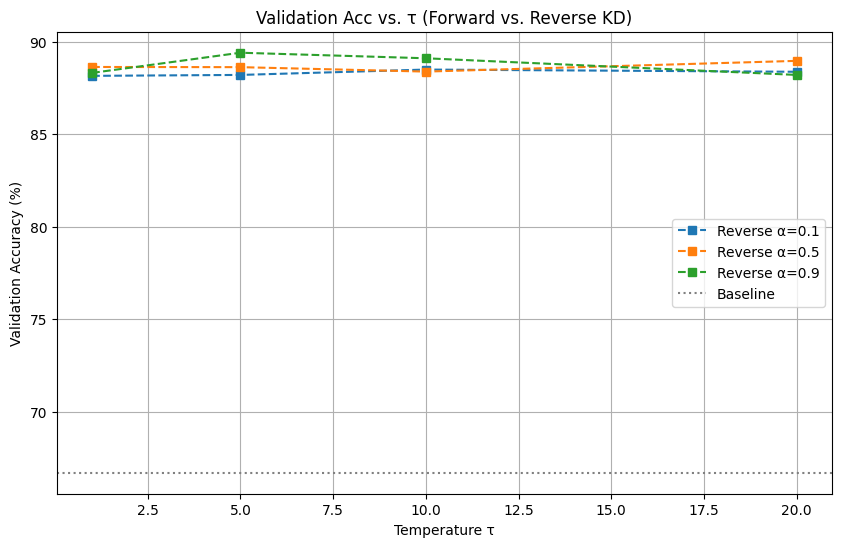

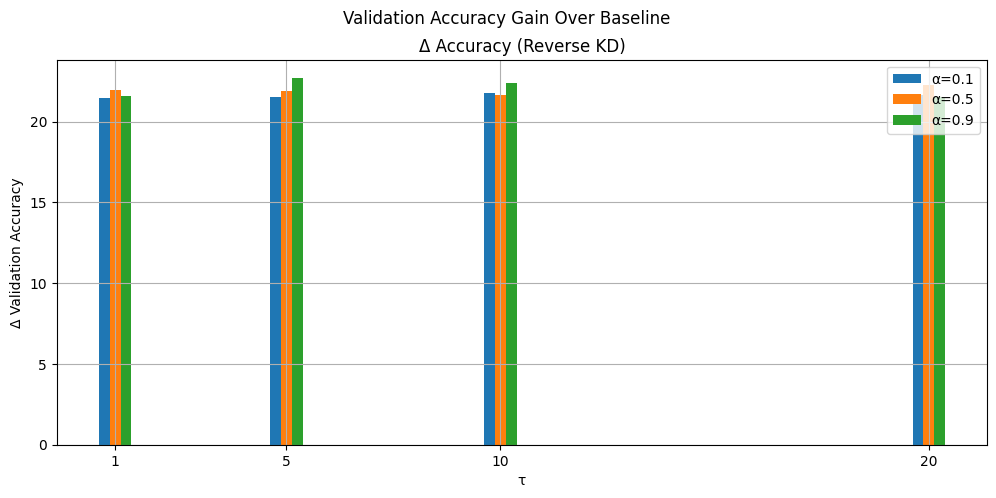


Final Metrics Table:
 τ    α  BaselineAcc  ReverseAcc  ΔReverse
 1  0.1         66.7       88.15     21.45
 5  0.1         66.7       88.20     21.50
10  0.1         66.7       88.49     21.79
20  0.1         66.7       88.37     21.67
 1  0.5         66.7       88.63     21.93
 5  0.5         66.7       88.62     21.92
10  0.5         66.7       88.38     21.68
20  0.5         66.7       88.96     22.26
 1  0.9         66.7       88.31     21.61
 5  0.9         66.7       89.40     22.70
10  0.9         66.7       89.10     22.40
20  0.9         66.7       88.20     21.50


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────────────────────
# 1) Build DataFrames for Reverse‑KD (from Part 6 or manual)
rev_results = [
    {'τ': 1,  'α': 0.1, 'ValAcc': 88.15}, {'τ': 1,  'α': 0.5, 'ValAcc': 88.63}, {'τ': 1,  'α': 0.9, 'ValAcc': 88.31},
    {'τ': 5,  'α': 0.1, 'ValAcc': 88.20}, {'τ': 5,  'α': 0.5, 'ValAcc': 88.62}, {'τ': 5,  'α': 0.9, 'ValAcc': 89.40},
    {'τ': 10, 'α': 0.1, 'ValAcc': 88.49}, {'τ': 10, 'α': 0.5, 'ValAcc': 88.38}, {'τ': 10, 'α': 0.9, 'ValAcc': 89.10},
    {'τ': 20, 'α': 0.1, 'ValAcc': 88.37}, {'τ': 20, 'α': 0.5, 'ValAcc': 88.96}, {'τ': 20, 'α': 0.9, 'ValAcc': 88.20},
]
rev_df = pd.DataFrame(rev_results)

# Attempt to load Forward‑KD sweep results if present
fwd_csv = "forward_sweep.csv"
if os.path.exists(fwd_csv):
    fwd_df = pd.read_csv(fwd_csv)
    has_forward = True
else:
    print(f"[Warning] {fwd_csv} not found – only Reverse‑KD will be plotted.")
    has_forward = False

# ────────────────────────────────────────────────────────────────────────────────
# 2) Pivot each into a (τ × α) table of validation accuracy
rev_table = rev_df.pivot(index='τ', columns='α', values='ValAcc')
if has_forward:
    fwd_table = fwd_df.pivot(index='τ', columns='α', values='ValAcc')

print("Reverse KD accuracy table:\n", rev_table, "\n")
if has_forward:
    print("Forward KD accuracy table:\n", fwd_table, "\n")

# ────────────────────────────────────────────────────────────────────────────────
# 3) Baseline CIFAR‑10 ValAcc for ResNet‑50 without any KD
baseline_acc = 66.70

# ────────────────────────────────────────────────────────────────────────────────
# 4) Plot ValAcc vs. τ for Forward and Reverse KD
plt.figure(figsize=(10,6))

if has_forward:
    for α in fwd_table.columns:
        plt.plot(fwd_table.index, fwd_table[α], 'o-', label=f"Forward α={α}")

for α in rev_table.columns:
    plt.plot(rev_table.index, rev_table[α], 's--', label=f"Reverse α={α}")

# horizontal line at baseline
plt.axhline(baseline_acc, color='gray', linestyle=':', label="Baseline")
plt.xlabel("Temperature τ")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Acc vs. τ (Forward vs. Reverse KD)")
plt.legend()
plt.grid(True)
plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# 5) Plot Accuracy Gain (Δ = ValAcc – baseline) as bar charts
delta_rev = rev_table - baseline_acc
if has_forward:
    delta_fwd = fwd_table - baseline_acc

x     = list(rev_table.index)
width = 0.25

# create subplots
fig, axes = plt.subplots(1, 2 if has_forward else 1, figsize=(12,5), sharey=True)

# Reverse KD bars
ax = axes[0] if has_forward else axes
for i, α in enumerate(delta_rev.columns):
    ax.bar([xi + i*width for xi in x],
           delta_rev[α],
           width,
           label=f"α={α}")
ax.set_xticks([xi + width for xi in x])
ax.set_xticklabels(x)
ax.set_title("Δ Accuracy (Reverse KD)")
ax.set_xlabel("τ")
ax.set_ylabel("Δ Validation Accuracy")
ax.legend()
ax.grid(True)

# Forward KD bars (if available)
if has_forward:
    ax2 = axes[1]
    for i, α in enumerate(delta_fwd.columns):
        ax2.bar([xi + i*width for xi in x],
                delta_fwd[α],
                width,
                label=f"α={α}")
    ax2.set_xticks([xi + width for xi in x])
    ax2.set_xticklabels(x)
    ax2.set_title("Δ Accuracy (Forward KD)")
    ax2.set_xlabel("τ")
    ax2.legend()
    ax2.grid(True)

plt.suptitle("Validation Accuracy Gain Over Baseline")
plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# 6) Build a final long‑form metrics table for export
rev_long = rev_table.reset_index().melt(id_vars='τ',
                                        var_name='α',
                                        value_name='ReverseAcc')
if has_forward:
    fwd_long = fwd_table.reset_index().melt(id_vars='τ',
                                            var_name='α',
                                            value_name='ForwardAcc')
    metrics = pd.merge(fwd_long, rev_long, on=['τ','α'])
    metrics['BaselineAcc'] = baseline_acc
    metrics['ΔForward']   = metrics['ForwardAcc'] - baseline_acc
    metrics['ΔReverse']   = metrics['ReverseAcc'] - baseline_acc
    cols = ['τ','α','BaselineAcc','ForwardAcc','ΔForward','ReverseAcc','ΔReverse']
else:
    metrics = rev_long.copy()
    metrics['BaselineAcc'] = baseline_acc
    metrics['ΔReverse']    = metrics['ReverseAcc'] - baseline_acc
    cols = ['τ','α','BaselineAcc','ReverseAcc','ΔReverse']

metrics = metrics[cols]
print("\nFinal Metrics Table:")
print(metrics.to_string(index=False))
